# Tutorial 4: Scattering calculations with Tully's models

In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.models.Tully as Tully
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import data_conv
from libra_py import dynamics_hdf5
from libra_py import dynamics_plotting
from libra_py import dynamics_exact
import util.libutil as comn
import time


import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

## 1. Define the model & plot the PES

In [2]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        res = Tully.Tully1(q, params)
    elif model==2:
        res = Tully.Tully2(q, params)
    elif model==3:
        res = Tully.Tully3(q, params)        

    return res


def potential(q, params):
    """
    Thin wrapper of the model Hamiltonians that can be used in 
    the fully-quantum calculations
    """

    # Diabatic properties
    obj = compute_model(q, params, Py2Cpp_int([0,0]))
    
    # Adiabatic properties
    nadi = len(params["E_n"])
    ndof = 1
    ham = nHamiltonian(nadi, nadi, ndof) # ndia, nadi, nnucl
    ham.init_all(2)
        

    ham.compute_diabatic(compute_model, q, params)    
    ham.compute_adiabatic(1);   
    
    
    obj.ham_adi = ham.get_ham_adi()    
    obj.dc1_adi = CMATRIXList() 
    
    for n in range(ndof):    
        x = ham.get_dc1_adi(n)
        for i in range(nadi):
            for j in range(nadi):
                if i!=j:
                    #pass
                    if math.fabs(x.get(i,j).real)>1e+10:
                        x.set(i,j, 0.0+0.0j)                    
                        x.set(j,i, 0.0+0.0j)
                        
        obj.dc1_adi.append( x )    
    
    
    return obj

In [3]:
param_sets = [ {"model":1, "E_n":[0.0, 0.0] },      
               {"model":2, "E_n":[0.0, 0.0] },
               {"model":3, "E_n":[0.0, 0.0] }
             ]


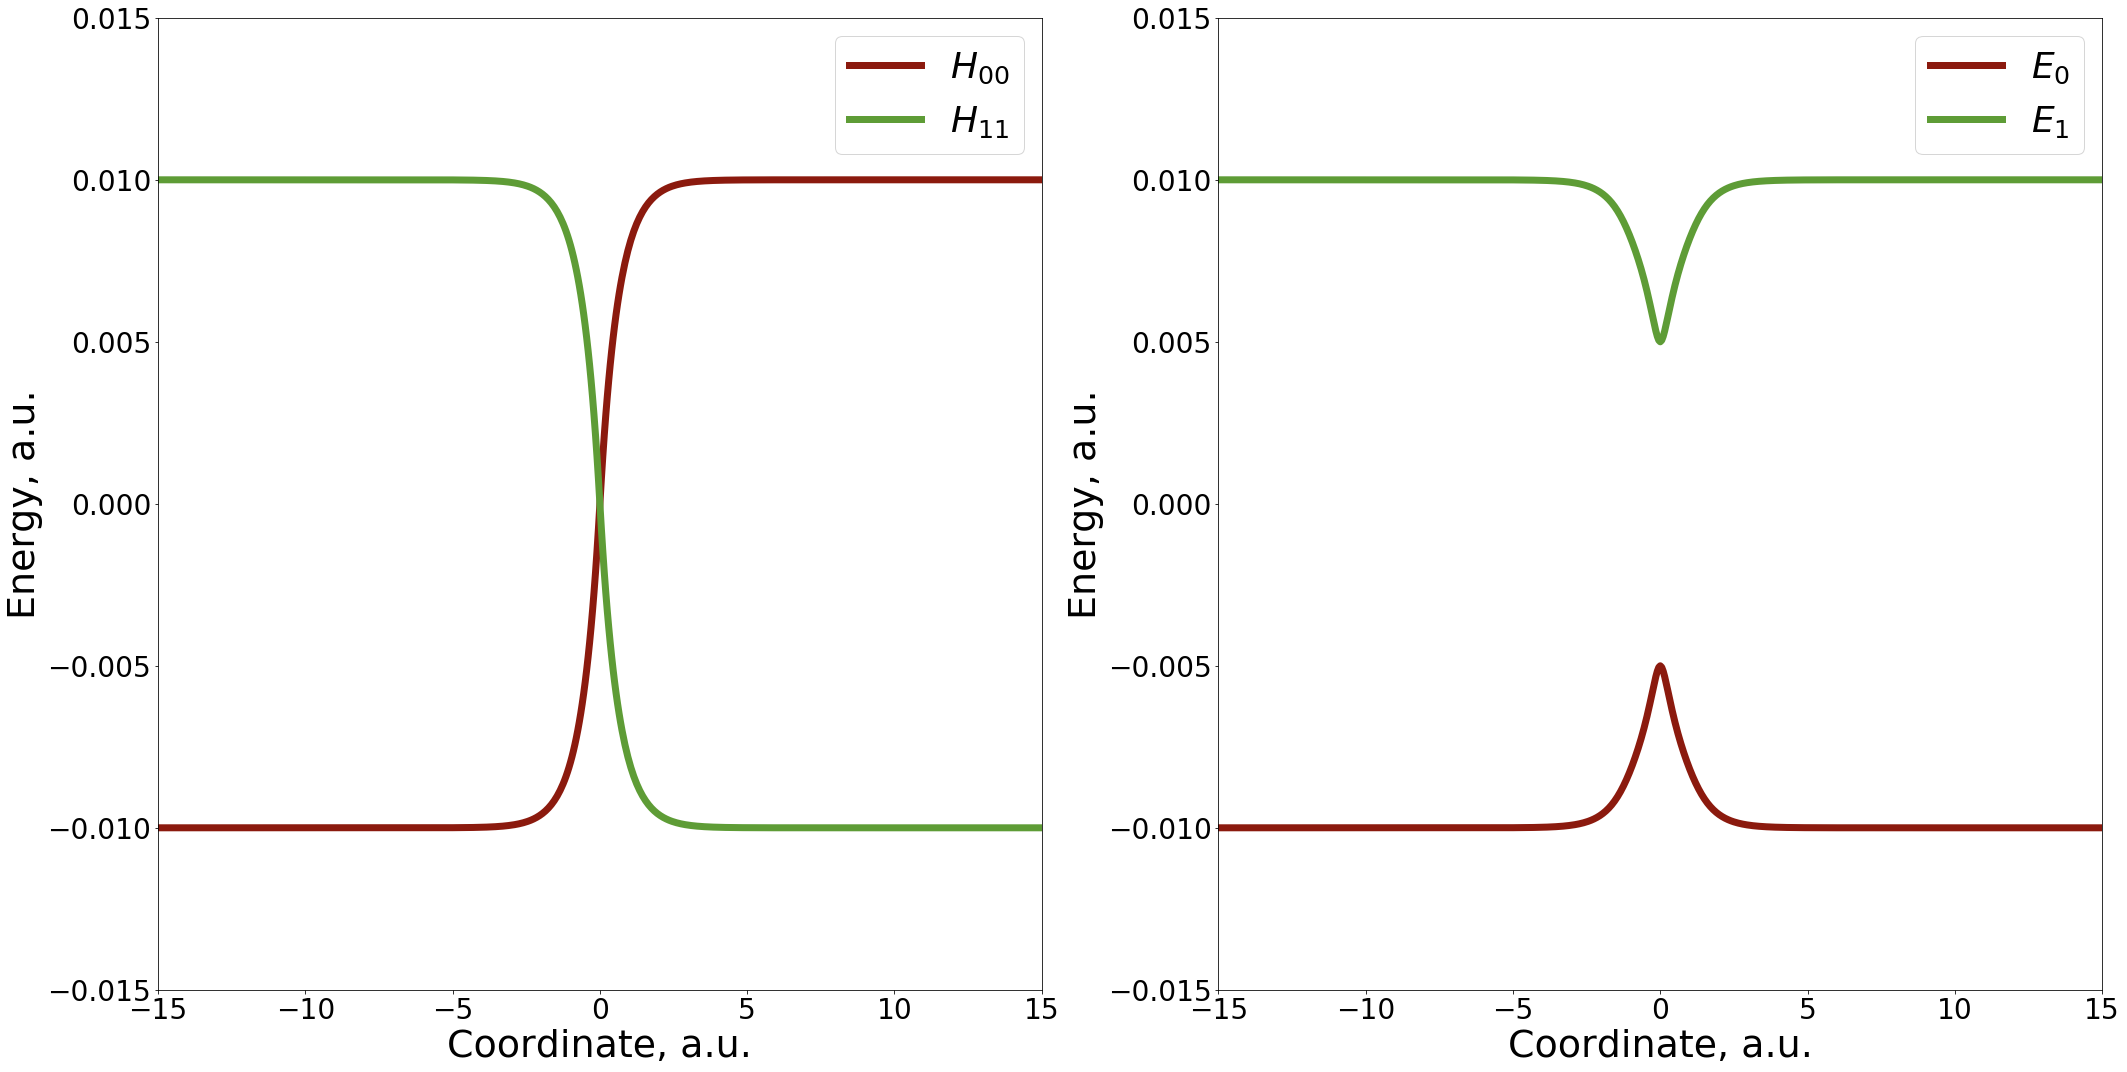

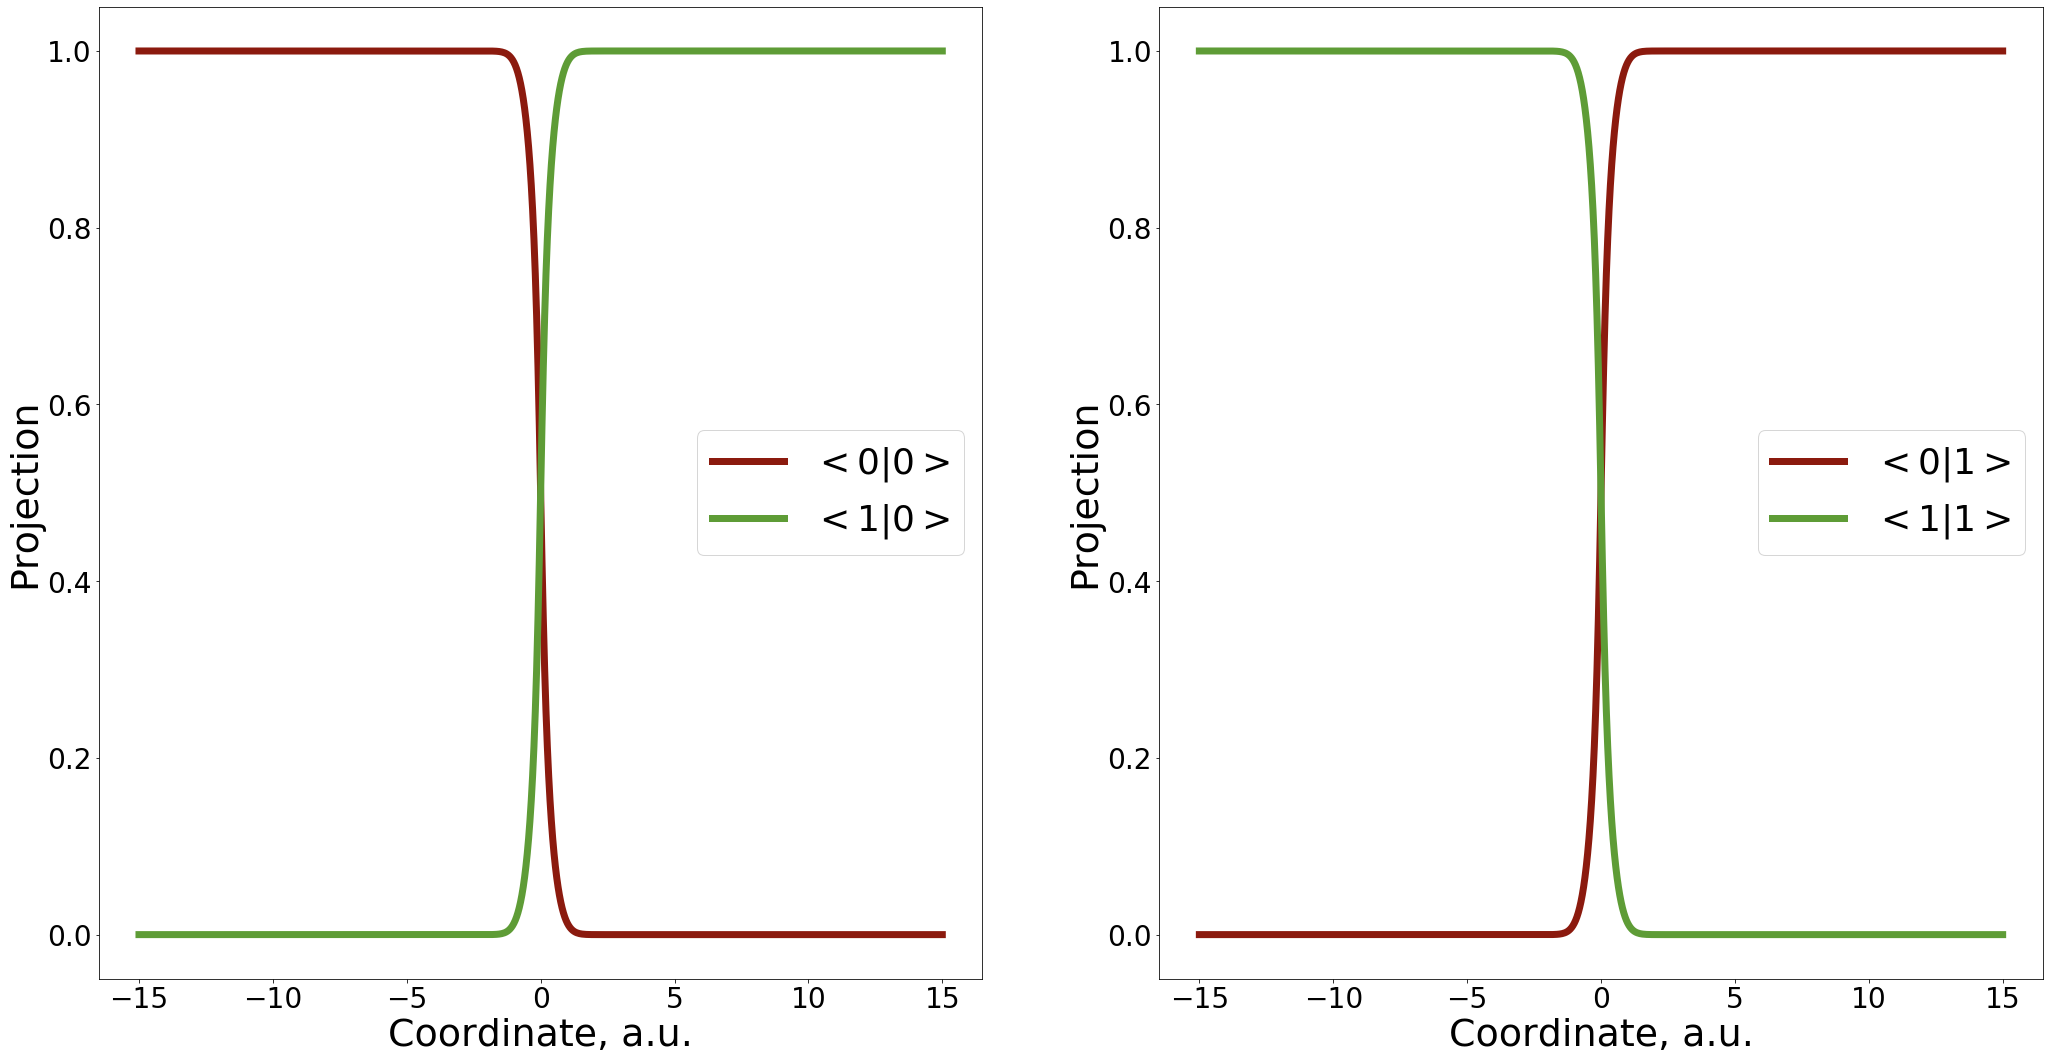

In [4]:
plot_params = {"colors": colors, "clrs_index": clrs_index, "xlim":[-15, 15], "ylim":[-0.015, 0.015 ]}
dynamics_plotting.plot_surfaces(compute_model, [ param_sets[0] ], [0,1], -15.0, 15.0, 0.05, plot_params)

## 2. Run the calculations

In [5]:
model_params = dict(param_sets[0])

properties_to_save = [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                       "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                       "pop_dia", "pop_adi", "q_dia", "q_adi", "q2_dia", "q2_adi", 
                       "p_dia", "p_adi", "p2_dia", "p2_adi",
                       "denmat_dia", "denmat_adi", "custom_pops",
                       "PSI_dia", "PSI_adi", "reciPSI_dia", "reciPSI_adi" ] 

params = { "nsteps":200, "dt":10.0, "progress_frequency":0.1,
           "rmin":[-35.0], "rmax":[35.0], "dx":[0.1], "nstates":2,
           "x0":[-10.0], "p0":[20.0], "istate":[1,0], "masses":[2000.0], "k":[0.001],           
           "integrator":"SOFT",
          
           "prefix":"Tut4-1",
           "hdf5_output_level":2, "compression_level":[0,0,0], "use_compression":1,
           "mem_output_level":0, 
           "txt_output_level":0,
           "properties_to_save": properties_to_save,
           "custom_pops":[  [0, [-40], [-5]],  [0, [-5], [5]], [0, [5], [40]], 
                            [1, [-40], [-5]],  [1, [-5], [5]], [1, [5], [40]]
                         ]
         }


In [6]:
params1 = dict(params)
params1.update({ "prefix":"Tut4-1"  })
res = dynamics_exact.run_relaxation( params1, potential, model_params )

ncustom_pops = 6
Run calculations with the dynamical parameters  {'nsteps': 200, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-35.0], 'rmax': [35.0], 'dx': [0.1], 'nstates': 2, 'x0': [-10.0], 'p0': [20.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut4-1', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'custom_pops', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi'], 'custom_pops': [[0, [-40], [-5]], [0, [-5], [5]], [0, [5], [40]], [1, [-40], [-5]], [1, [-5], [5]], [1, [5], [40]]]}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, 0.0], 'A': 0.01, 'B': 1.6, 'C': 0.005, 'D': 1.0}
Norm

## 3. Plot the results

In [7]:
with h5py.File("Tut4-1/data.hdf", 'r') as f:
    t = list(f["time/data"][:])
    print(t)
    
    #print(list(f["boxed_pops/0/data"][:, 0, 0]))
    
    print(list(f["custom_pops/data"][:, 0, 0, 0]))
    
    print(list(f["pop_adi/data"][:, 0, 0]))

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720.0, 730.0, 740.0, 750.0, 760.0, 770.0, 780.0, 790.0, 800.0, 810.0, 820.0, 830.0, 840.0, 850.0, 860.0, 870.0, 880.0, 890.0, 900.0, 910.0, 920.0, 930.0, 940.0, 950.0, 960.0, 970.0, 980.0, 990.0, 1000.0, 1010.0, 1020.0, 1030.0, 1040.0, 1050.0, 1060.0, 1070.0, 1080.0, 1090.0, 1100.0, 1110.0, 1120.0, 1130.0, 1140.0, 1150.0, 1160.0, 1170.0, 1180.0, 1190.0, 1200.0, 1210.0, 1220.0, 1230.0, 1240.0, 1250.0, 1260.0, 1270.0, 1280.0, 1290.0, 1300.0, 1310.0, 1320.0, 1330.0, 1340.0, 1350.0, 1360.0, 1370.0, 1380.0

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


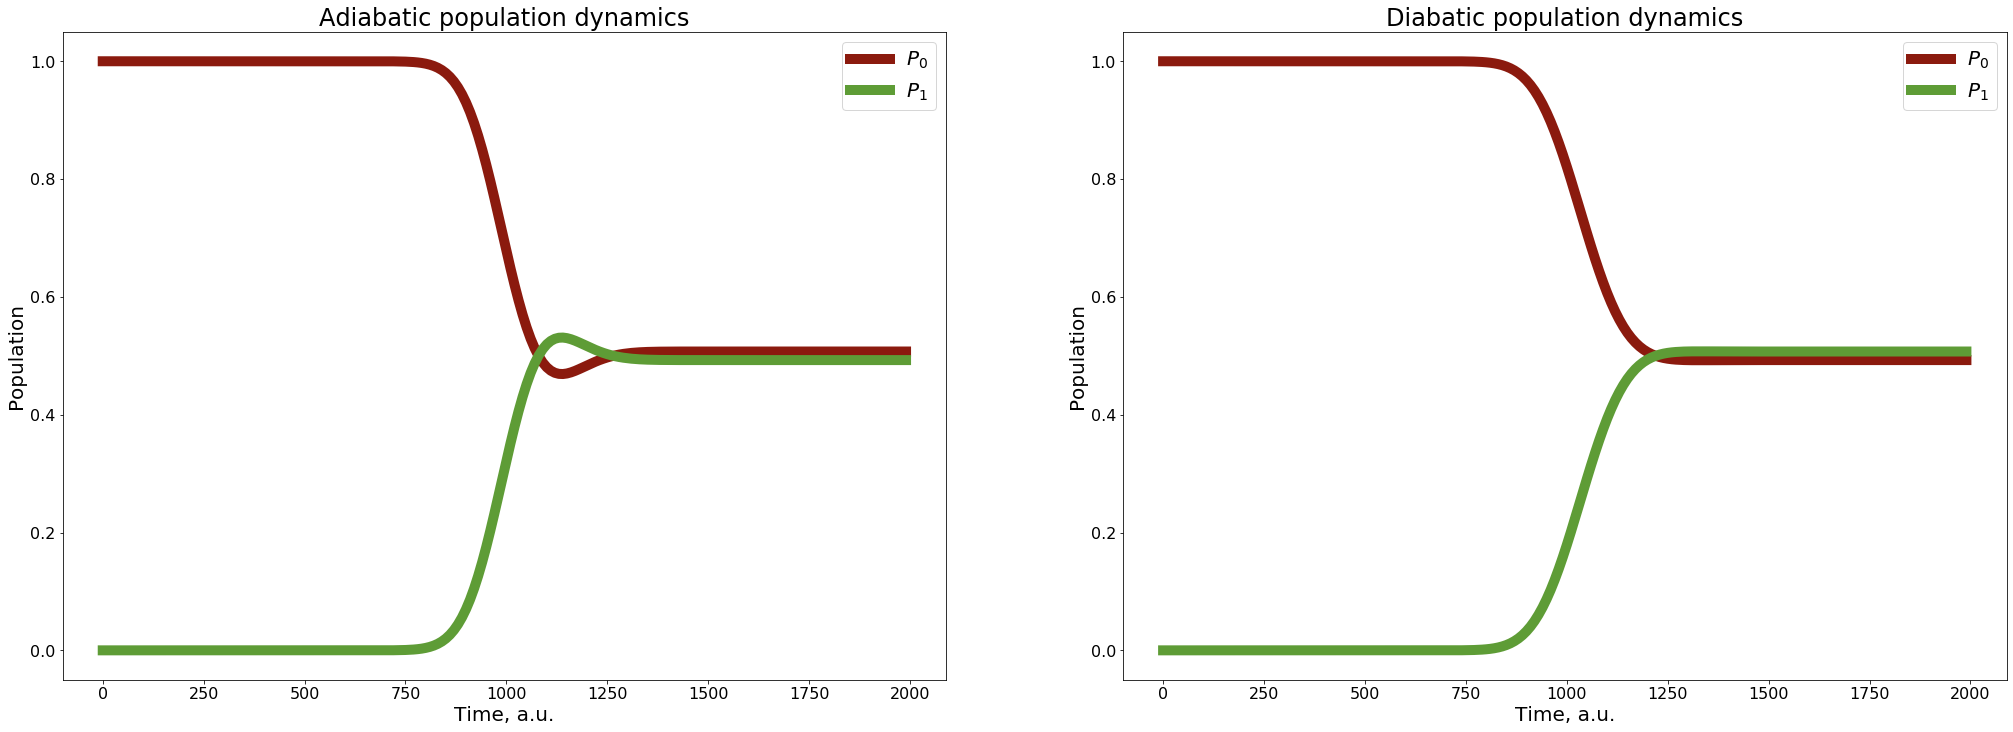

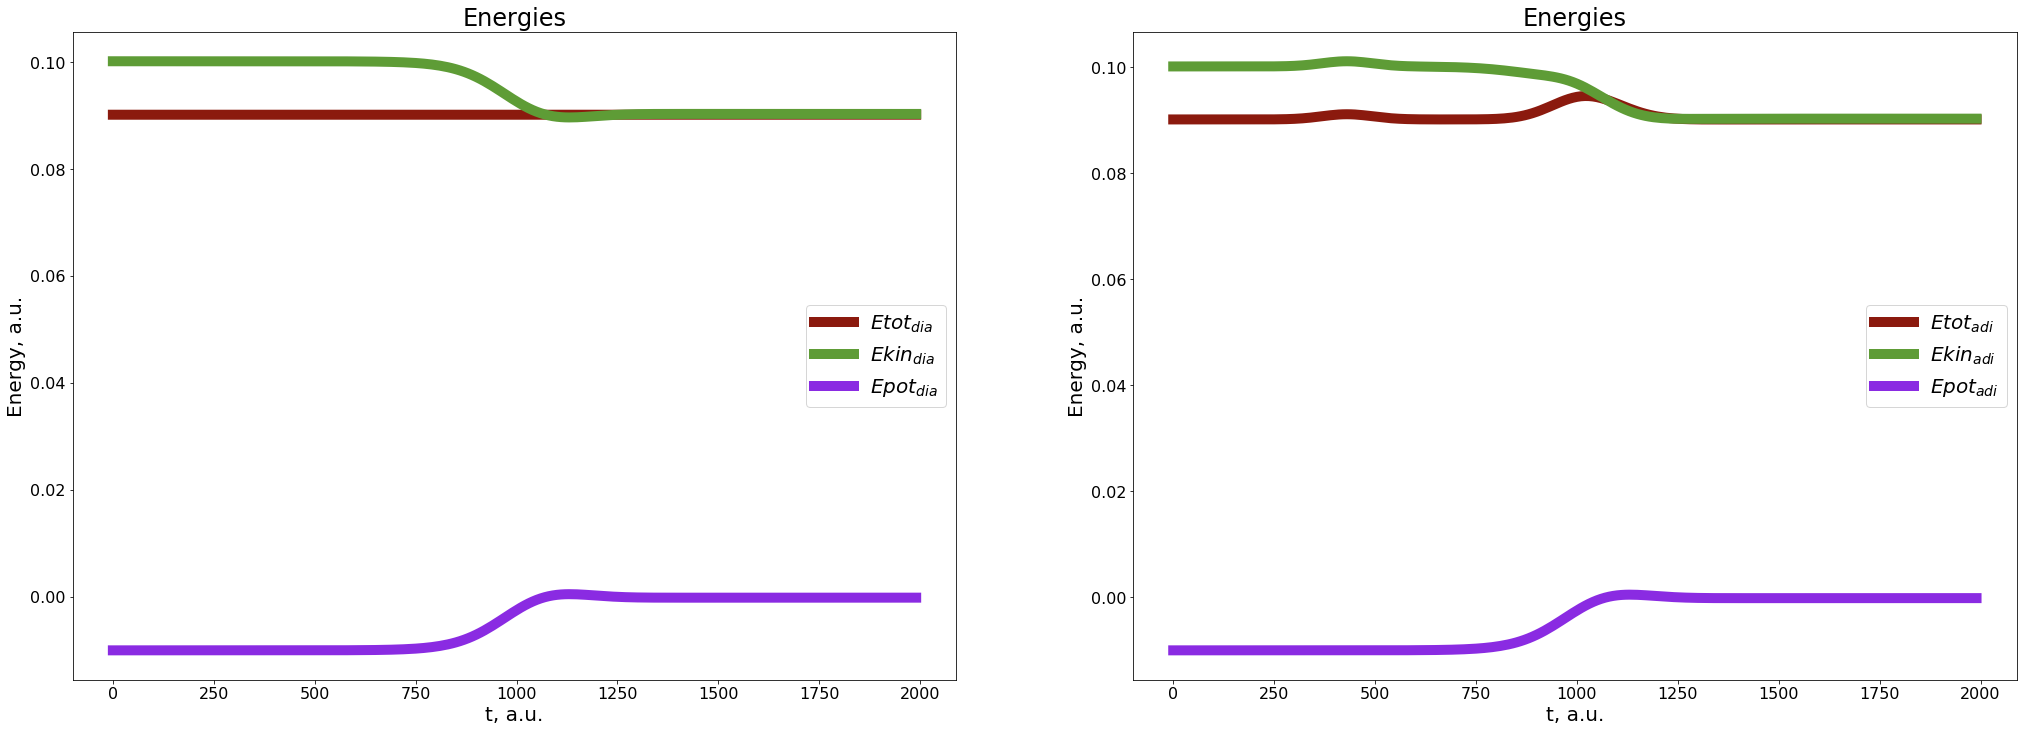

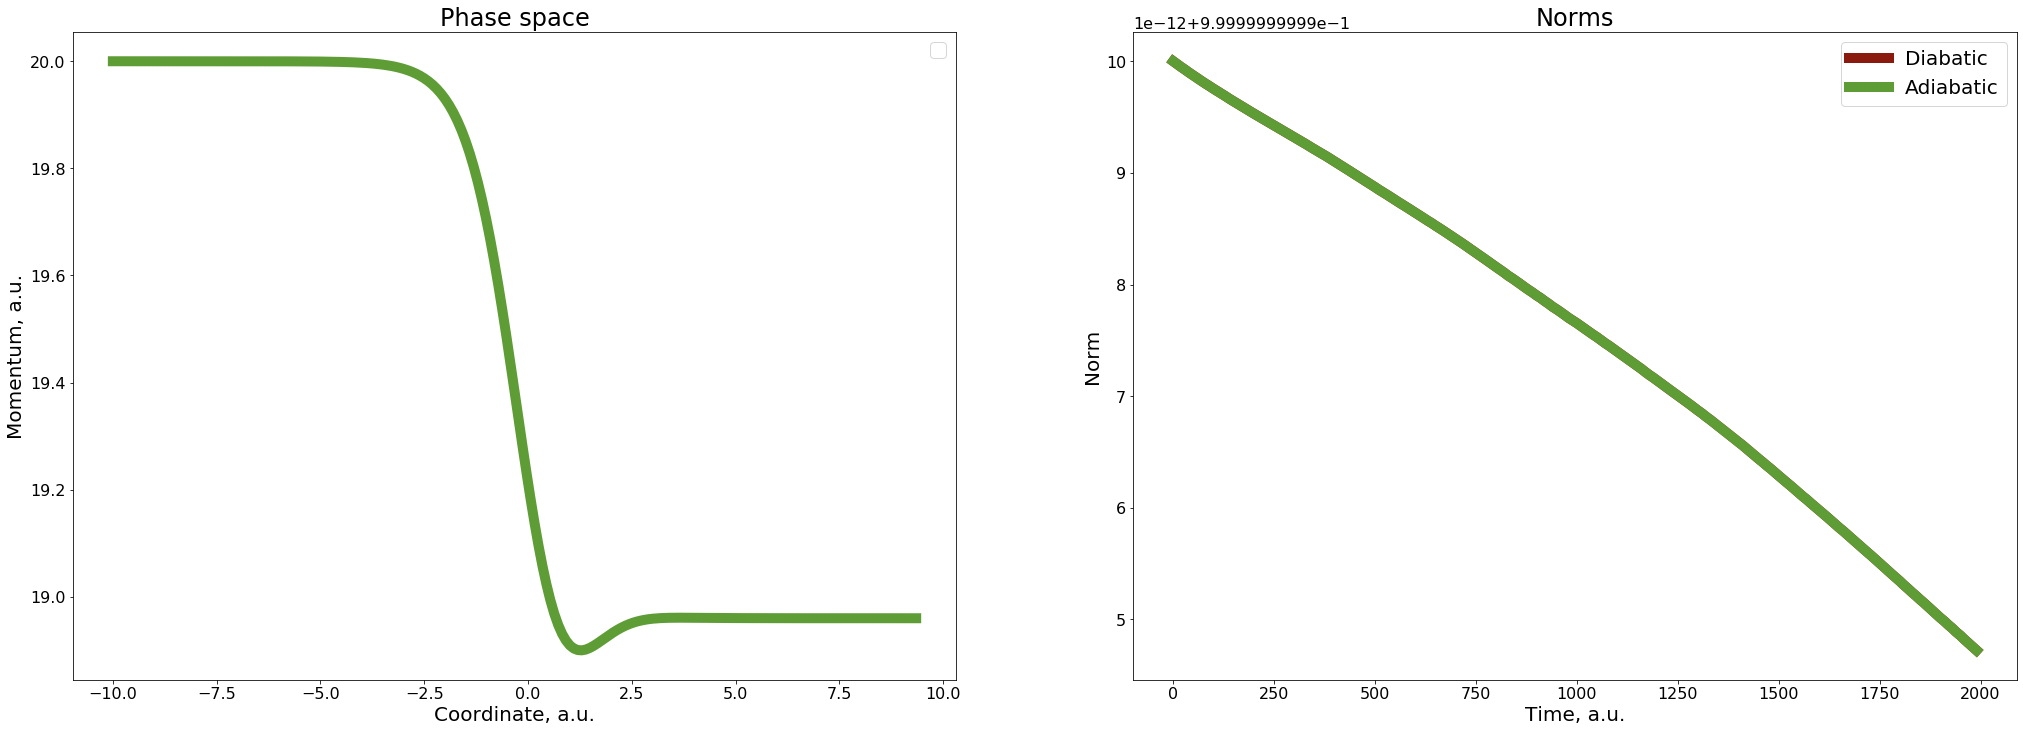

In [8]:
plot_params = {"prefix":"Tut4-1", "filename":"data.hdf", "hdf5_output_level":2,
                "which_dofs":[0],  "which_adi_states":[0, 1], "which_dia_states":[0, 1],                
                "properties_to_save": 
                          [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                            "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                            "pop_dia", "pop_adi", "q_dia", "q_adi", "q2_dia", "q2_adi", 
                            "p_dia", "p_adi", "p2_dia", "p2_adi",
                            "denmat_dia", "denmat_adi", "custom_pops",
                            "PSI_dia", "PSI_adi", "reciPSI_dia", "reciPSI_adi" ] 
              }


dynamics_exact.plot_hdf5(plot_params)

In [9]:
def plot_custom_pops(plot_params):
    """
    This function is meant to plot the results stored in the hdf files generated by the exact dynamics runs

    Args:

        prefix ( string ): the name of the directory containing the input HDF5 file
            This directory will also be used to output the generated picture files [ default : "out"]
        filename ( string ): name of the HDF5 file to read [ default: "data.hdf"]
        output_level ( int ): the level of info contained in the HDF5 file [ default : 3]        
        which_adi_states ( list of ints ) : indices of the adiabatic states to print [ default: [0] ]
        which_dia_states ( list of ints ) : indices of the diabatic states to print [ default: [0] ]
        colors ( dictionary ): the definition of the colors to use
        clrs_index ( list of strings ) : defines the mapping of the colors on integers and vice versa 
    

    """
    
    plt.rc('axes', titlesize=24)      # fontsize of the axes title
    plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
    plt.rc('legend', fontsize=20)     # legend fontsize
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

    plt.rc('figure.subplot', left=0.2)
    plt.rc('figure.subplot', right=0.95)
    plt.rc('figure.subplot', bottom=0.13)
    plt.rc('figure.subplot', top=0.88)


    colors = {}

    colors.update({"11": "#8b1a0e"})  # red       
    colors.update({"12": "#FF4500"})  # orangered 
    colors.update({"13": "#B22222"})  # firebrick 
    colors.update({"14": "#DC143C"})  # crimson   

    colors.update({"21": "#5e9c36"})  # green
    colors.update({"22": "#006400"})  # darkgreen  
    colors.update({"23": "#228B22"})  # forestgreen
    colors.update({"24": "#808000"})  # olive      

    colors.update({"31": "#8A2BE2"})  # blueviolet
    colors.update({"32": "#00008B"})  # darkblue  

    colors.update({"41": "#2F4F4F"})  # darkslategray

    clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]


    # Parameters and dimensions
    critical_params = [  ] 
    default_params = {  "prefix":"out", "filename":"data.hdf", "hdf5_output_level":2,                        
                        "colors":colors, "clrs_index":clrs_index,
                        "figs":[]
                     }
    comn.check_input(plot_params, default_params, critical_params)
        

            
    filename = plot_params["filename"]
    prefix = plot_params["prefix"]
    hdf5_output_level = plot_params["hdf5_output_level"]        
    colors = plot_params["colors"]
    clrs_index = plot_params["clrs_index"]    
    figs = plot_params["figs"]    
    
    out_prefix = prefix
    

        
    
    with h5py.File(F"{prefix}/{filename}", 'r') as f:
    
        t = None
        if "time" in properties_to_save:                        
            t = list(f["time/data"][:])
    
        #=============== Populations ======================        

        if t != None:            
            
            nfigs = len(figs)
        
            for ifig in range(nfigs):
        
                plt.figure(ifig, figsize=(12, 12)) # dpi=300, frameon=False)                               
            
                plt.subplot(1, 1, 1)
                
                #plt.ylim(0, 1)
                
                plt.title(F'{figs[ifig][0]}' )
                plt.xlabel('Time, a.u.')
                plt.ylabel('Population')
                
                
                nlines = len(figs[ifig])
                for i in range(1, nlines):
                    
                    line_label = figs[ifig][i][0] 
                    pop_type = figs[ifig][i][1]
                    istate = figs[ifig][i][2]
                    line_color_index = figs[ifig][i][3]
                    clr = colors[clrs_index[ line_color_index ]]
                                        
                    Pi = list(f["custom_pops/data"][:, pop_type, istate, 0])      
                    
                    plt.plot(t, Pi, label=F'{line_label}', linewidth=10, color = clr)   
                    plt.legend()

                plt.savefig(F"{prefix}/Custom_pops_{i-1}.png", dpi=300)
                plt.savefig(F"{prefix}/Custom_pops_{i-1}.pdf", dpi=300)
                    
        
        plt.show()
        plt.close()
        


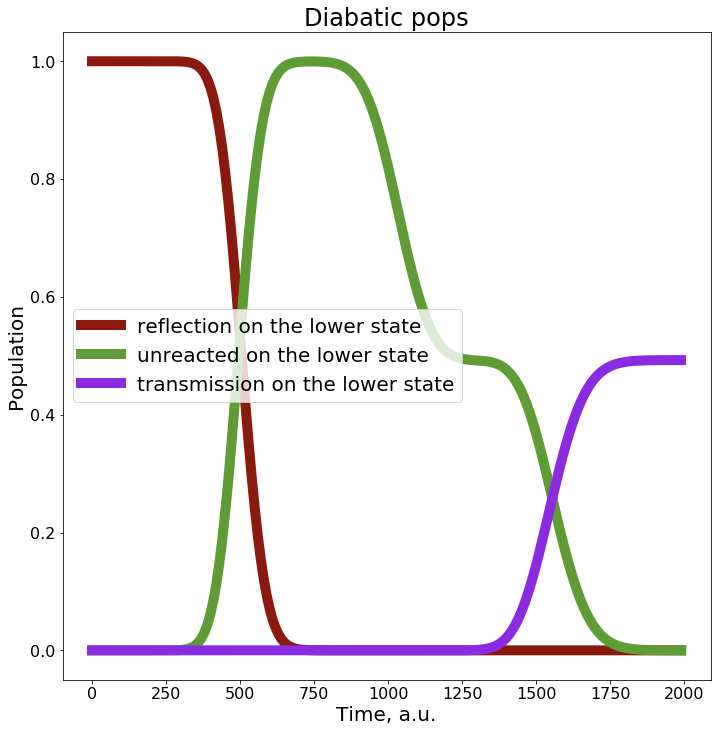

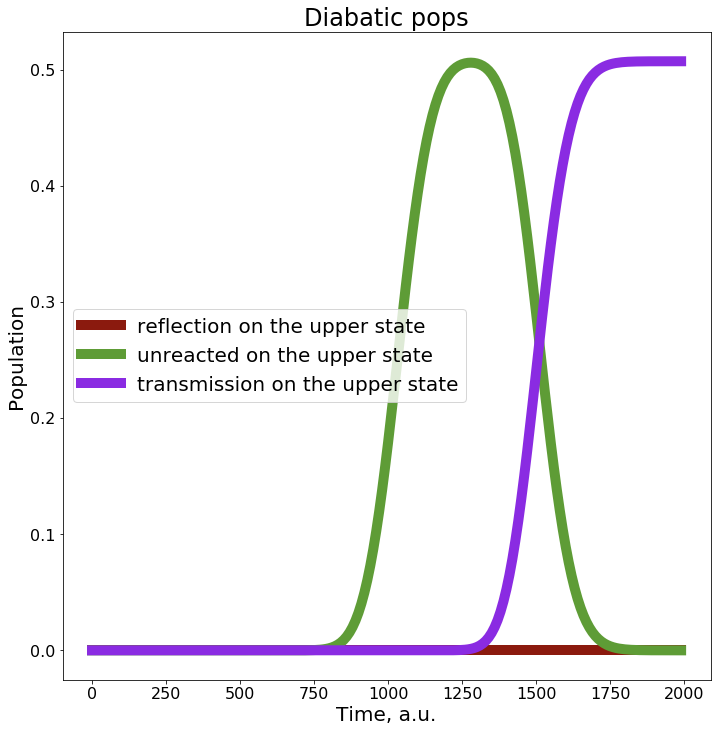

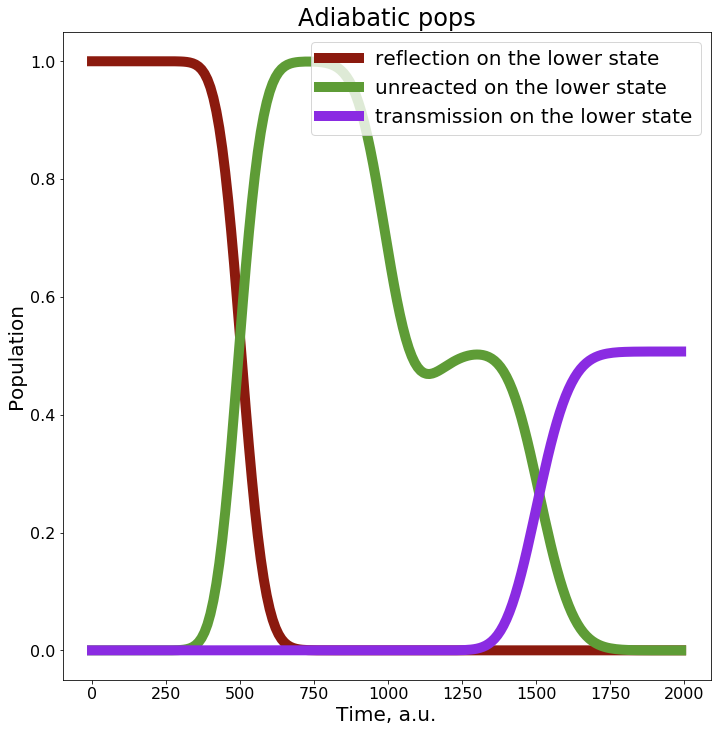

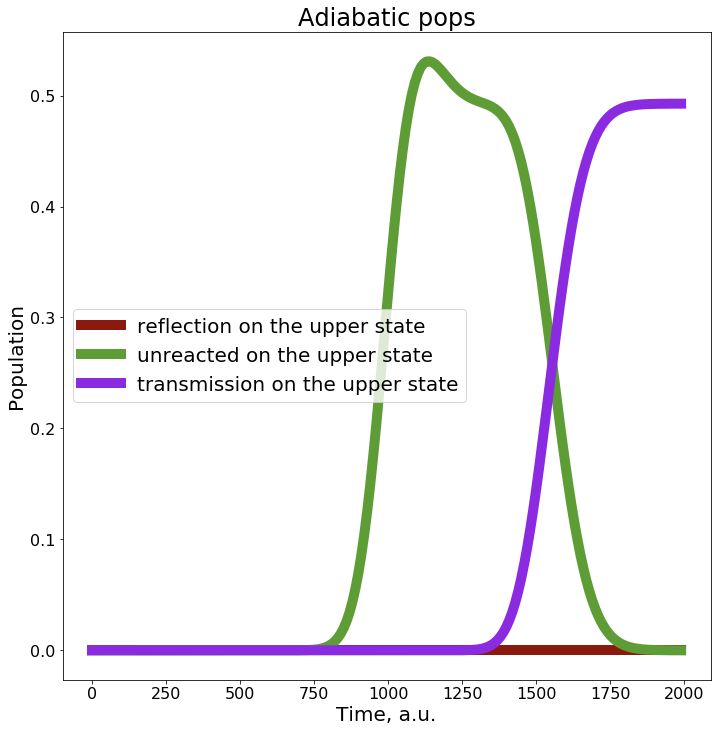

In [10]:
         

_plot_params = {  "prefix":"Tut4-1", "filename":"data.hdf", "hdf5_output_level":2,                        
                 "colors":colors, "clrs_index":clrs_index,
                    "figs":[ [ "Diabatic pops",  
                               ["reflection on the lower state",   0, 0, 0],
                               ["unreacted on the lower state",    1, 0, 1],
                               ["transmission on the lower state", 2, 0, 2]
                             ],
                              
                             [ "Diabatic pops",  
                               ["reflection on the upper state",   0, 1, 0],
                               ["unreacted on the upper state",    1, 1, 1],
                               ["transmission on the upper state", 2, 1, 2]
                             ],
                            
                             [ "Adiabatic pops",  
                               ["reflection on the lower state",   3, 0, 0],
                               ["unreacted on the lower state",    4, 0, 1],
                               ["transmission on the lower state", 5, 0, 2]
                             ],
                              
                             [ "Adiabatic pops",  
                               ["reflection on the upper state",   3, 1, 0],
                               ["unreacted on the upper state",    4, 1, 1],
                               ["transmission on the upper state", 5, 1, 2]
                             ]                            
                            
                           ]
                 }


plot_custom_pops(_plot_params)

## Scattering probabilities

Now, lets repeat the calculations many times, with different initial momenta and save all the results in different folders

In [12]:
prefix = "Tut4-2"


model_params = dict(param_sets[0])

properties_to_save = [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                       "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                       "pop_dia", "pop_adi", "q_dia", "q_adi", "q2_dia", "q2_adi", 
                       "p_dia", "p_adi", "p2_dia", "p2_adi",
                       "denmat_dia", "denmat_adi", "custom_pops",
                       "PSI_dia", "PSI_adi", "reciPSI_dia", "reciPSI_adi" ] 

params = { "nsteps":200, "dt":10.0, "progress_frequency":0.1,
           "rmin":[-35.0], "rmax":[35.0], "dx":[0.1], "nstates":2,
           "x0":[-10.0], "p0":[20.0], "istate":[1,0], "masses":[2000.0], "k":[0.001],           
           "integrator":"SOFT",
          
           "prefix":"Tut4-2",
           "hdf5_output_level":2, "compression_level":[0,0,0], "use_compression":1,
           "mem_output_level":0, 
           "txt_output_level":0,
           "properties_to_save": properties_to_save,
           "custom_pops":[  [0, [-40], [-5]],  [0, [-5], [5]], [0, [5], [40]], 
                            [1, [-40], [-5]],  [1, [-5], [5]], [1, [5], [40]]
                         ]
         }


if not os.path.isdir(prefix):
    os.mkdir(prefix)

    
P0 = [1.0, 2.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0, 13.0, 15.0, 18.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]

ninit = len(P0)


for i in range(ninit):
    
    print(F"=============== initial momentum {P0[i]} ============")
    
    if not os.path.isdir(F"{prefix}/{i}"):
        os.mkdir(F"{prefix}/{i}")
    
    params1 = dict(params)
    params1.update({"prefix": F"{prefix}/{i}", "p0":[P0[i] ], "nsteps":int(200 * (200.0/P0[i])) })
    
    dynamics_exact.run_relaxation( params1, potential, model_params )

    


=============== initial momentum 1.0 ============
ncustom_pops = 6
Run calculations with the dynamical parameters  {'nsteps': 40000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-35.0], 'rmax': [35.0], 'dx': [0.1], 'nstates': 2, 'x0': [-10.0], 'p0': [1.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut4-2/0', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'custom_pops', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi'], 'custom_pops': [[0, [-40], [-5]], [0, [-5], [5]], [0, [5], [40]], [1, [-40], [-5]], [1, [-5], [5]], [1, [5], [40]]]}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, 

 step= 0
 step= 500
 step= 1000
 step= 1500
 step= 2000
 step= 2500
 step= 3000
 step= 3500
 step= 4000
 step= 4500
Calculation time = 867.9544162750244 seconds
=============== initial momentum 10.0 ============
ncustom_pops = 6
Run calculations with the dynamical parameters  {'nsteps': 4000, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-35.0], 'rmax': [35.0], 'dx': [0.1], 'nstates': 2, 'x0': [-10.0], 'p0': [10.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut4-2/6', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'custom_pops', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi'], 'custom_pops': [[0, [-40]

Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999999
Ekin (dia) =  0.1001767766953358
Ekin (adi) =  0.10017677669529541
Epot (dia) =  -0.00999999823059383
Epot (adi) =  -0.00999999823059383
 step= 0
 step= 200
 step= 400
 step= 600
 step= 800
 step= 1000
 step= 1200
 step= 1400
 step= 1600
 step= 1800
Calculation time = 305.9327836036682 seconds
=============== initial momentum 25.0 ============
ncustom_pops = 6
Run calculations with the dynamical parameters  {'nsteps': 1600, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-35.0], 'rmax': [35.0], 'dx': [0.1], 'nstates': 2, 'x0': [-10.0], 'p0': [25.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'Tut4-2/12', 'hdf5_output_level': 2, 'compression_level': [0, 0, 0], 'use_compression': 1, 'mem_output_level': 0, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_ad

Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999999
Ekin (dia) =  0.04134089000950039
Ekin (adi) =  0.04134089000933545
Epot (dia) =  -0.00999999823059383
Epot (adi) =  -0.00999999823059383
 step= 0
 step= 80
 step= 160
 step= 240
 step= 320
 step= 400
 step= 480
 step= 560
 step= 640
 step= 720
Calculation time = 218.4837384223938 seconds


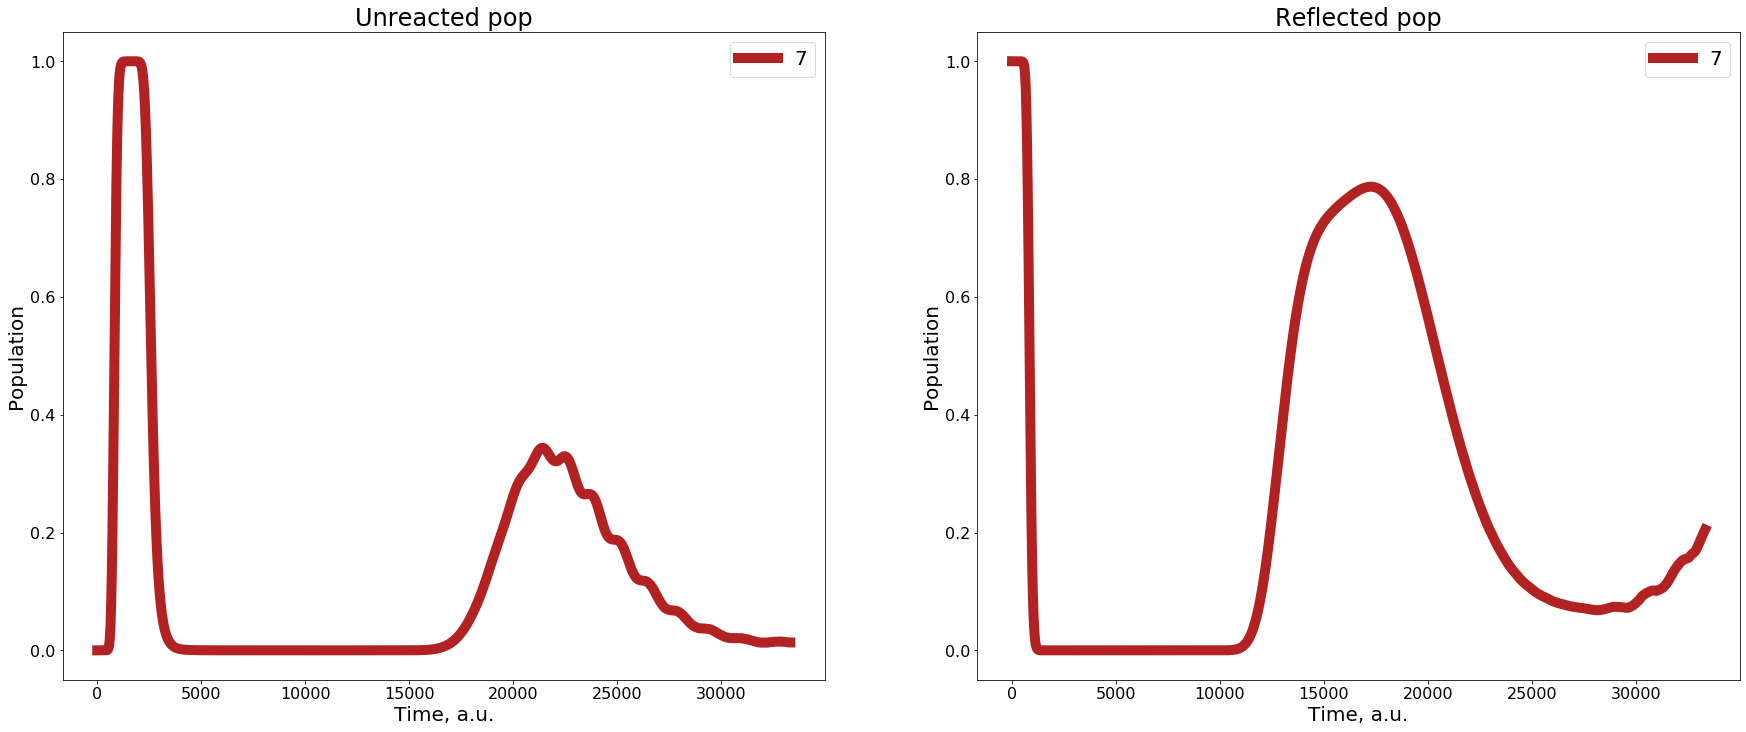

In [21]:

P0 = [1.0, 2.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0, 13.0, 15.0, 18.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]

ninit = len(P0)

plt.figure(1, figsize=(48, 12)) # dpi=300, frameon=False)                               
plt.subplot(1, 3, 1)
plt.title("Unreacted pop")
plt.xlabel('Time, a.u.')
plt.ylabel('Population')


for i in [7]: #range(ninit):
    
    nclrs = len(clrs_index)
    clr = colors[clrs_index[ i % nclrs]]
    
    with h5py.File(F"Tut4-2/{i}/data.hdf", 'r') as f:
        
        t = list(f["time/data"][:])
        
        p0 = list(f["custom_pops/data"][:, 4, 0, 0])  # adiabatic not reacted, on state 0
        p1 = list(f["custom_pops/data"][:, 4, 1, 0])  # adiabatic not reacted, on state 1
        p_unreact = []
        
        sz = len(p0)        
        for j in range(sz):
            p_unreact.append(p0[j] + p1[j])
        
        #print(F" ===  init cond = {i} ===")
        #print(p)
        
        plt.plot(t, p_unreact, label=F'{i}', linewidth=10, color = clr)   
        plt.legend()


        
plt.subplot(1, 3, 2)
plt.title("Reflected pop")
plt.xlabel('Time, a.u.')
plt.ylabel('Population')


for i in [7]: #range(ninit):
    
    nclrs = len(clrs_index)
    clr = colors[clrs_index[ i % nclrs]]
    
    with h5py.File(F"Tut4-2/{i}/data.hdf", 'r') as f:
        
        t = list(f["time/data"][:])
        
        p0 = list(f["custom_pops/data"][:, 3, 0, 0])  # adiabatic not reacted, on state 0
        p1 = list(f["custom_pops/data"][:, 3, 1, 0])  # adiabatic not reacted, on state 1
        p_refl = []
        
        sz = len(p0)        
        for j in range(sz):
            p_refl.append(p0[j] + p1[j])
        
        #print(F" ===  init cond = {i} ===")
        #print(p)
        
        plt.plot(t, p_refl, label=F'{i}', linewidth=10, color = clr)   
        plt.legend()

        
    
    